In [1]:
import yfinance as yf
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import wrangle


In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500.index = pd.to_datetime(sp500.index)


In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<AxesSubplot:xlabel='Date'>

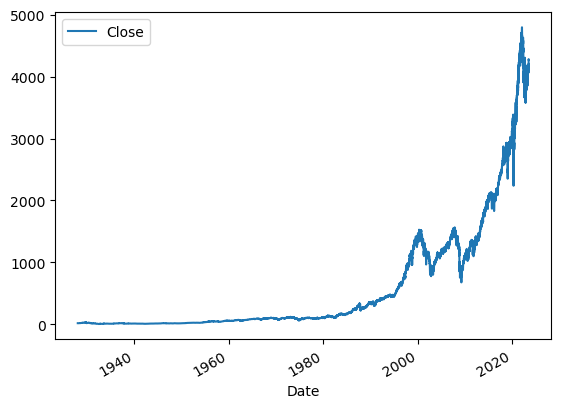

In [5]:
sp500.plot.line(y="Close", use_index=True)


#### add to prep - 
* create tomorrow 
* lower case
* drop stock split, dividend
* add target column 0=down 1= up


In [6]:
# creating tomorrow column = prior day closing price
# this will alos be the target as its what we are trying to guess
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow
Date,,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0,17.500000
...,...,...,...,...,...,...,...,...
2023-05-30 00:00:00-04:00,4226.709961,4231.100098,4192.180176,4205.520020,4228510000,0.0,0.0,4179.830078
2023-05-31 00:00:00-04:00,4190.740234,4195.439941,4166.149902,4179.830078,5980670000,0.0,0.0,4221.020020
2023-06-01 00:00:00-04:00,4183.029785,4232.430176,4171.640137,4221.020020,4391860000,0.0,0.0,4282.370117


In [7]:
sp500.columns = [col.lower() for col in sp500]


In [8]:
sp500['stock splits'].nunique

<bound method IndexOpsMixin.nunique of Date
1927-12-30 00:00:00-05:00    0.0
1928-01-03 00:00:00-05:00    0.0
1928-01-04 00:00:00-05:00    0.0
1928-01-05 00:00:00-05:00    0.0
1928-01-06 00:00:00-05:00    0.0
                            ... 
2023-05-30 00:00:00-04:00    0.0
2023-05-31 00:00:00-04:00    0.0
2023-06-01 00:00:00-04:00    0.0
2023-06-02 00:00:00-04:00    0.0
2023-06-05 00:00:00-04:00    0.0
Name: stock splits, Length: 23971, dtype: float64>

In [9]:
# since are data set is a market index and not tradable there should be 0 splits
all_zero = (sp500['stock splits'] == 0).count()
print(all_zero)
# drop the column
print(sp500.shape)

23971
(23971, 8)


In [10]:
# same for dividends
all_zero = (sp500['dividends'] == 0).count()
print(all_zero)

23971


In [11]:
# dropping unused columns
sp500 = sp500.drop(['stock splits', 'dividends'], axis=1)


In [12]:
sp500.head()

,open,high,low,close,volume,tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000


In [13]:
#setting target as tomorrow
# setting it as an int so that i get 0 for down days and 1 for up days
sp500["target"] = (sp500["tomorrow"] > sp500["close"]).astype(int)

In [14]:
sp500.index

Index([1927-12-30 00:00:00-05:00, 1928-01-03 00:00:00-05:00,
       1928-01-04 00:00:00-05:00, 1928-01-05 00:00:00-05:00,
       1928-01-06 00:00:00-05:00, 1928-01-09 00:00:00-05:00,
       1928-01-10 00:00:00-05:00, 1928-01-11 00:00:00-05:00,
       1928-01-12 00:00:00-05:00, 1928-01-13 00:00:00-05:00,
       ...
       2023-05-22 00:00:00-04:00, 2023-05-23 00:00:00-04:00,
       2023-05-24 00:00:00-04:00, 2023-05-25 00:00:00-04:00,
       2023-05-26 00:00:00-04:00, 2023-05-30 00:00:00-04:00,
       2023-05-31 00:00:00-04:00, 2023-06-01 00:00:00-04:00,
       2023-06-02 00:00:00-04:00, 2023-06-05 00:00:00-04:00],
      dtype='object', name='Date', length=23971)

In [15]:
# Convert index to timezone-naive datetime format 
sp500.index = pd.to_datetime(sp500.index, utc=True).normalize()

In [16]:
# use a copy that only has dates from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()


In [17]:
sp500.index

DatetimeIndex(['1990-01-02 00:00:00+00:00', '1990-01-03 00:00:00+00:00',
               '1990-01-04 00:00:00+00:00', '1990-01-05 00:00:00+00:00',
               '1990-01-08 00:00:00+00:00', '1990-01-09 00:00:00+00:00',
               '1990-01-10 00:00:00+00:00', '1990-01-11 00:00:00+00:00',
               '1990-01-12 00:00:00+00:00', '1990-01-15 00:00:00+00:00',
               ...
               '2023-05-22 00:00:00+00:00', '2023-05-23 00:00:00+00:00',
               '2023-05-24 00:00:00+00:00', '2023-05-25 00:00:00+00:00',
               '2023-05-26 00:00:00+00:00', '2023-05-30 00:00:00+00:00',
               '2023-05-31 00:00:00+00:00', '2023-06-01 00:00:00+00:00',
               '2023-06-02 00:00:00+00:00', '2023-06-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=8421, freq=None)

In [18]:
sp500.head()

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
1990-01-02 00:00:00+00:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00+00:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00+00:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00+00:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00+00:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [19]:
# dropping time since they are all the same and I only need the dates
sp500.index = sp500.index.date

In [20]:
sp500.head()

,open,high,low,close,volume,tomorrow,target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


TypeError: 'str' object is not callable

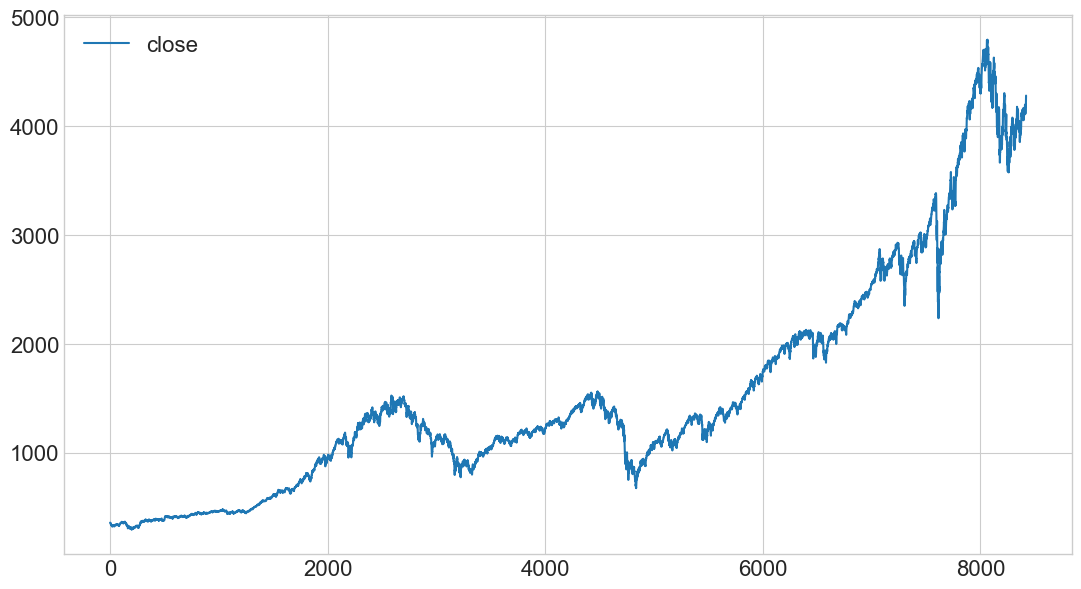

In [182]:
df.plot.line(y="close", use_index=True)
plt.title('S&P 500 Performance Since 1990')
xlabel('Year')
ylabel('Value in $USD')
plt.show()


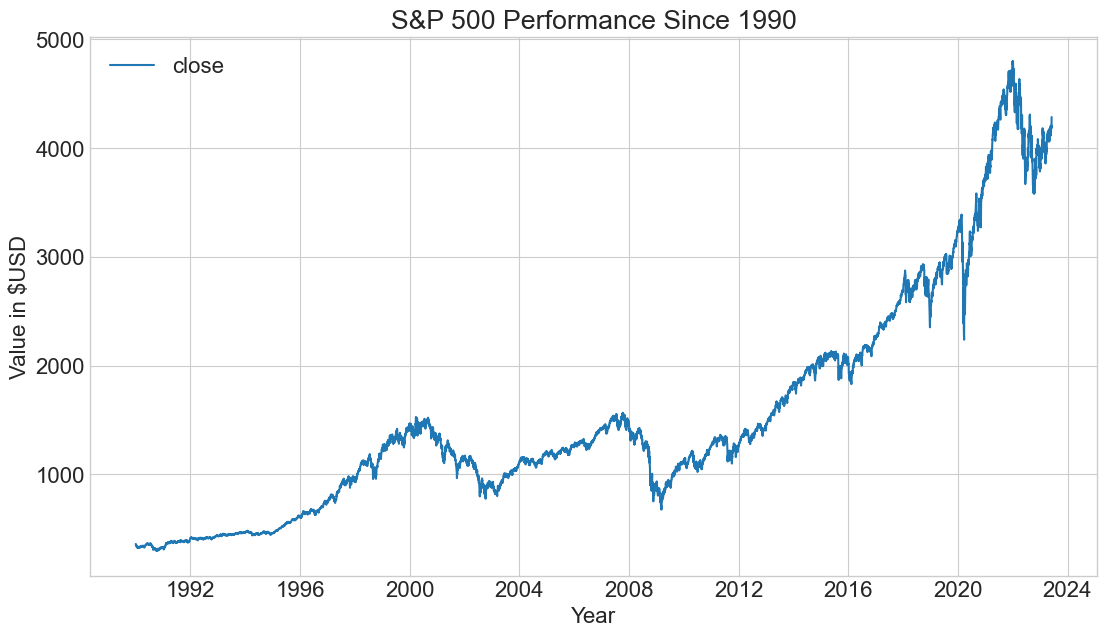

In [199]:
df.plot.line(y="close",x="date", title="S&P 500 Performance Since 1990",use_index=True)
#plt.title(f'S&P 500 Performance Since 1990')
plt.xlabel('Year')
plt.ylabel('Value in $USD')
plt.show()

<AxesSubplot:>

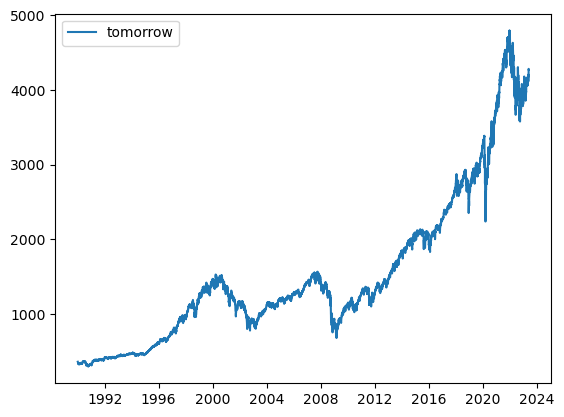

In [22]:
sp500.plot.line(y="tomorrow", use_index=True)


<AxesSubplot:>

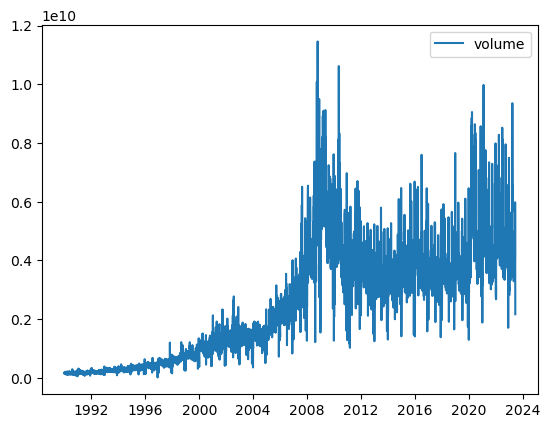

In [23]:
sp500.plot.line(y="volume", use_index=True)


<AxesSubplot:ylabel='Frequency'>

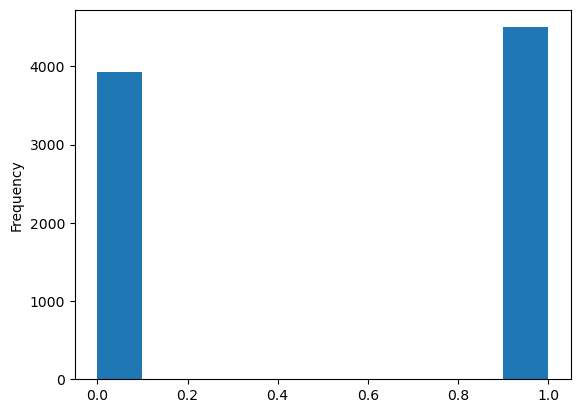

In [24]:
sp500.target.plot.hist()


open


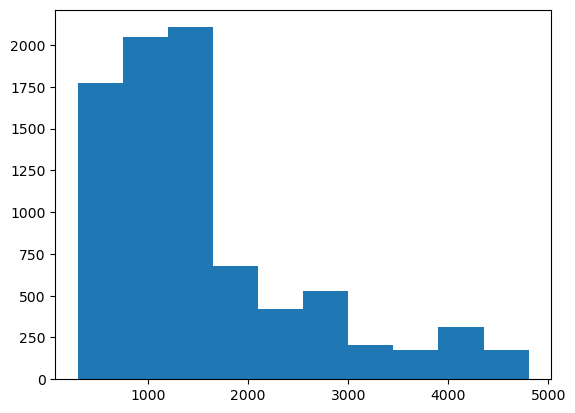

high


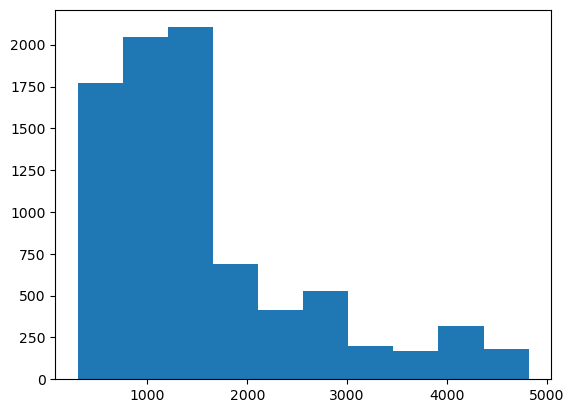

low


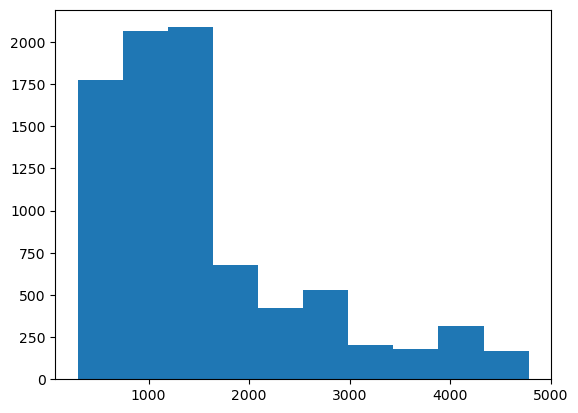

close


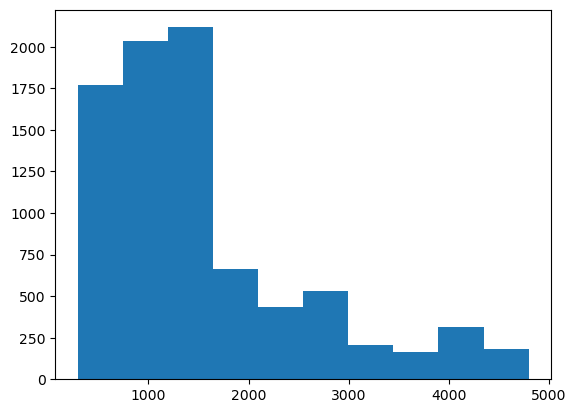

volume


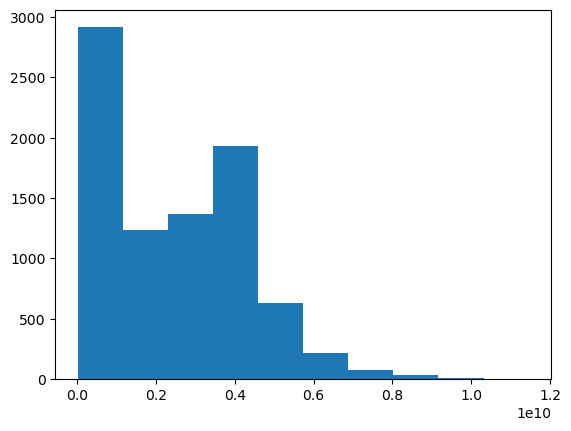

tomorrow


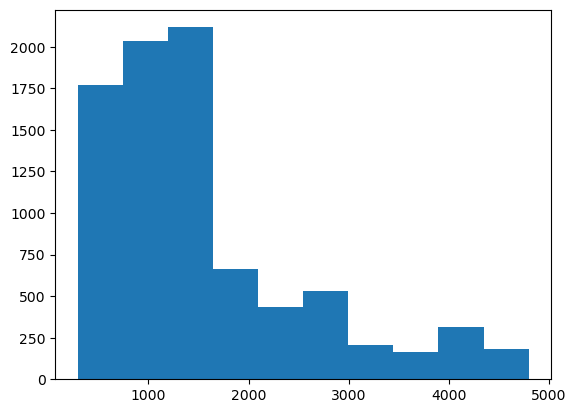

target


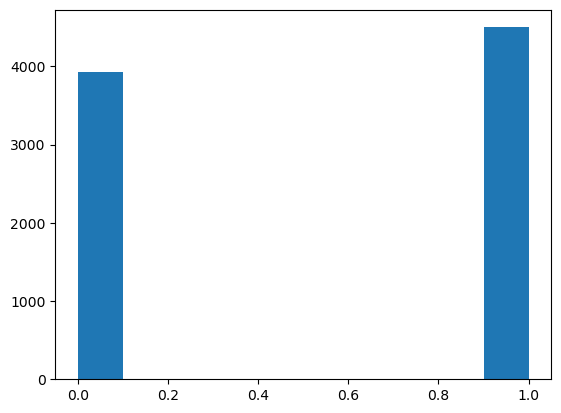

In [26]:
for col in sp500.columns:
    print(col)
    plt.hist(sp500[col])
    plt.show()

#### add to prep - datetime index

In [27]:
# need to add this to prep 
sp500.index = pd.to_datetime(sp500.index, format = '%Y %m %d')

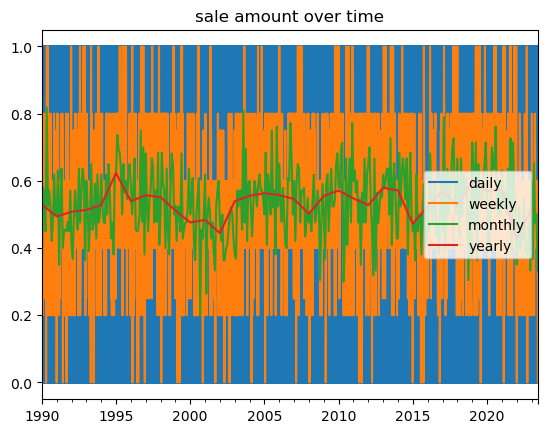

In [28]:
sp500.resample('D').mean().target.plot(label='daily')
sp500.resample('W').mean().target.plot(label='weekly')
sp500.resample('M').mean().target.plot(label='monthly')
sp500.resample('Y').mean().target.plot(label='yearly')


plt.title('sale amount over time')
plt.legend()
plt.show()

### Baseline

In [29]:
#how often is it up / down
sp500.target.value_counts()

1    4498
0    3923
Name: target, dtype: int64

In [30]:
# most importantly % of time the market is up
sp500.target.value_counts().sum()

8421

In [31]:
# so its up 53.4141% of the time this is a good baseline
(sp500.target.value_counts()) / (sp500.target.value_counts().sum())

1    0.534141
0    0.465859
Name: target, dtype: float64

### How to split 
* i think the smaller test set will work for this

In [32]:
# split data using 2023 to date as the test set
train = sp500.loc[:'2022'].copy()
test = sp500.loc['2023'].copy()


In [33]:
print(train.shape)
test.shape

(8315, 7)


(106, 7)

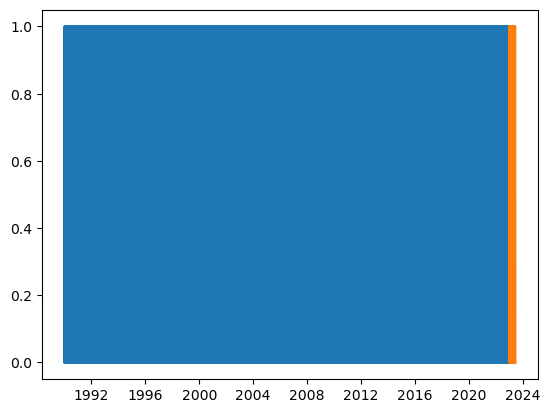

In [34]:
plt.plot(train.index, train.target)
plt.plot(test.index, test.target)
plt.show()

In [35]:
# split using last 20% as test
train_size = 0.80 
n = sp500.shape[0] 
test_start_index = round(train_size * n) 
train = sp500.iloc[:test_start_index] 
test = sp500.iloc[test_start_index:] 

In [36]:
print(train.shape)
test.shape

(6737, 7)


(1684, 7)

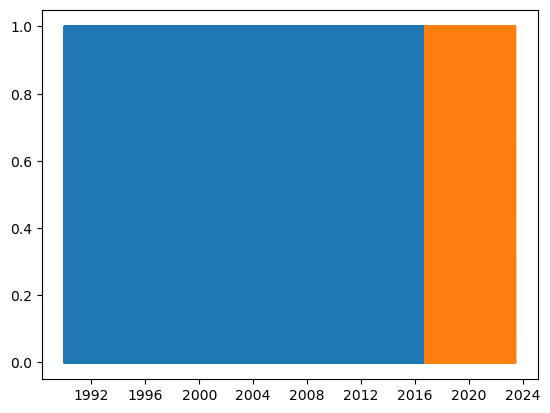

In [37]:
plt.plot(train.index, train.target)
plt.plot(test.index, test.target)
plt.show()

In [38]:
# split data using 2023 to date as the test set
train = sp500.loc[:'2022'].copy()
test = sp500.loc['2023'].copy()

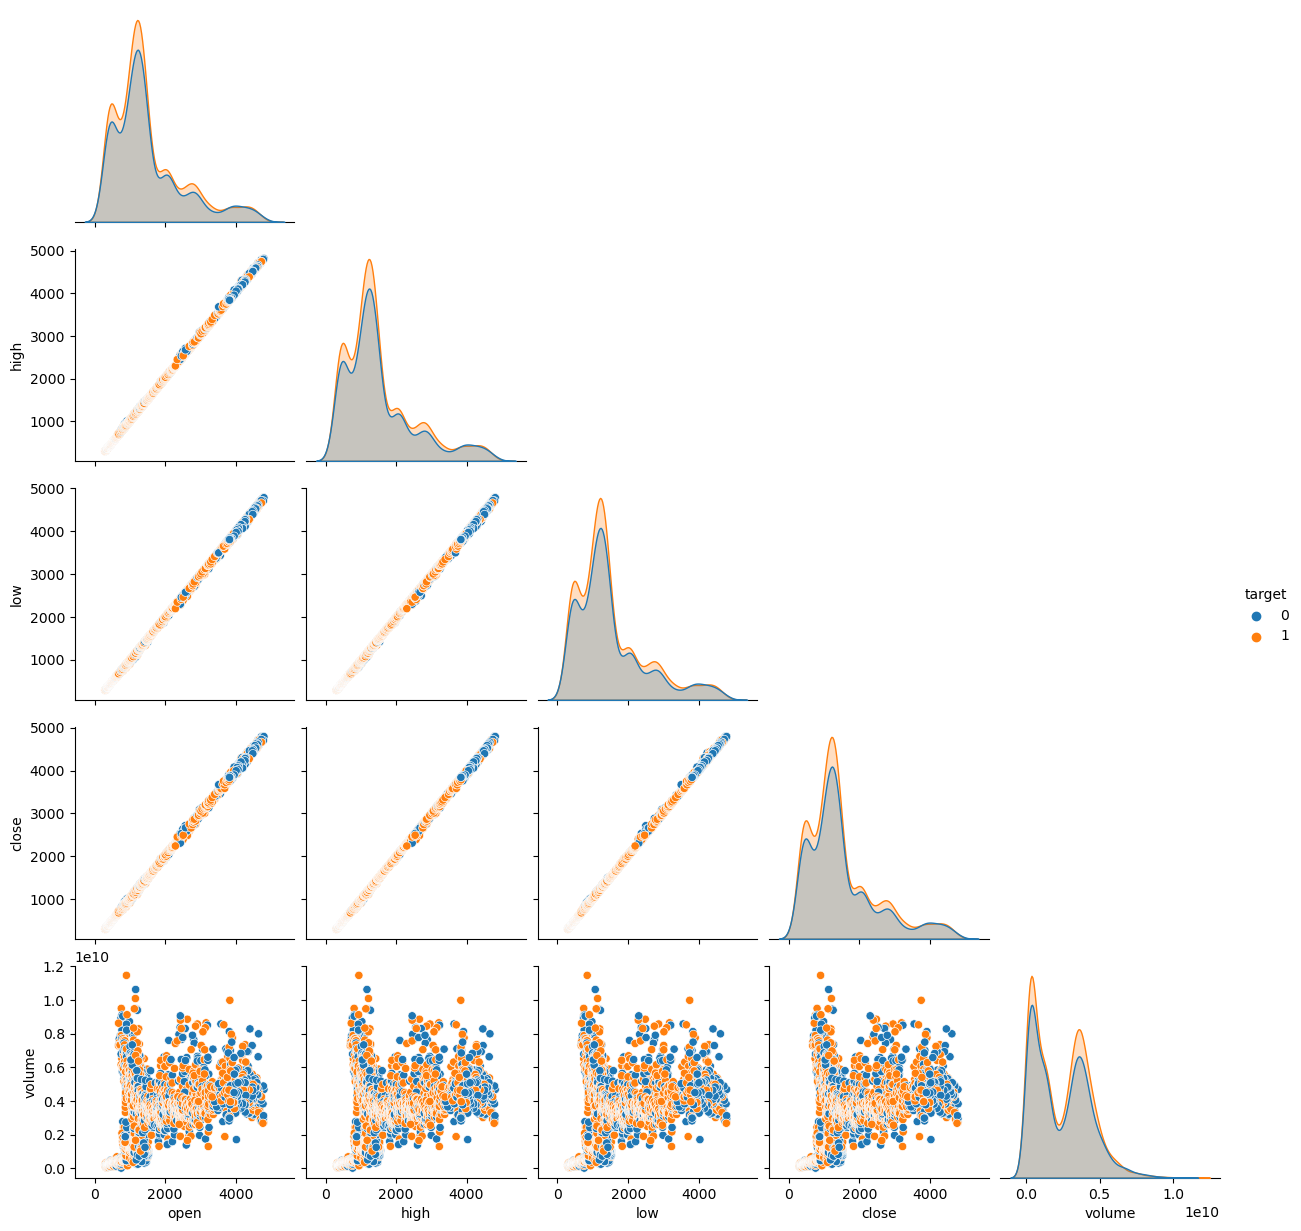

In [39]:
sns.pairplot(data=train, hue='target', vars=['open', 'high', 'low', 'close','volume'],corner=True)


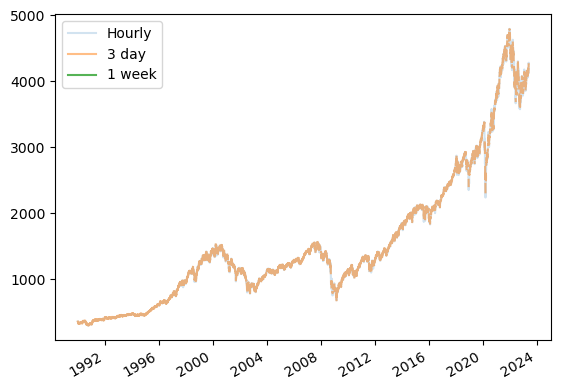

In [40]:
y=sp500.tomorrow
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()



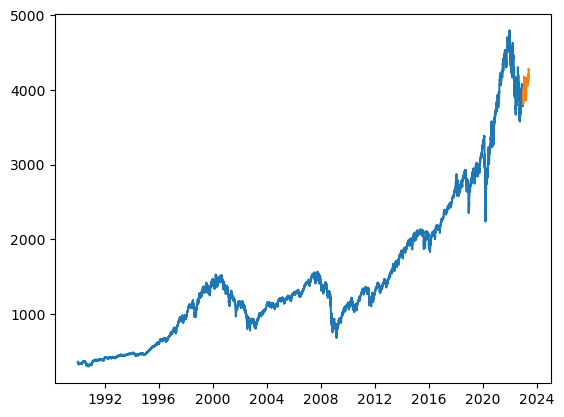

In [41]:
#small split
plt.plot(train.index, train.tomorrow)
plt.plot(test.index, test.tomorrow)
plt.show()

<AxesSubplot:title={'center':'Average week-to-week change in tomorrow'}>

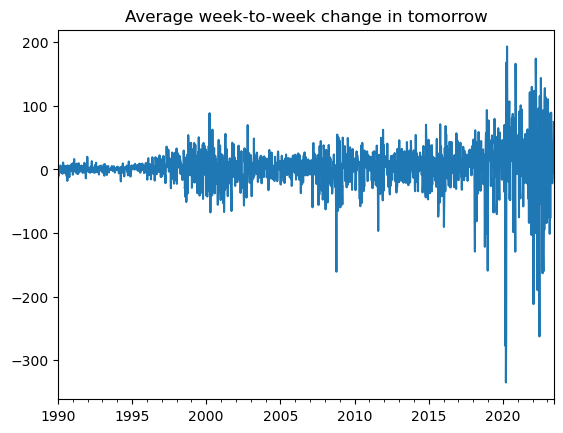

In [42]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in tomorrow')


<AxesSubplot:title={'center':'Average month-to-month change in tomorrow'}>

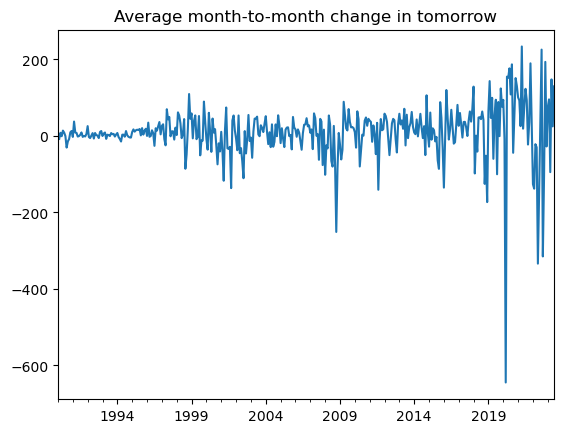

In [43]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in tomorrow')


<AxesSubplot:title={'center':'Seasonal Plot'}>

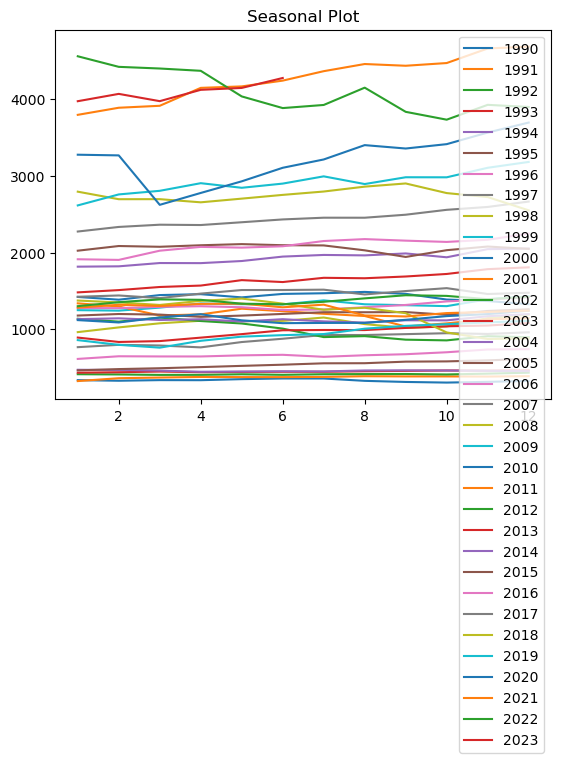

In [44]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


/var/folders/2s/5h_f818x4h11v8k6kc_6g1700000gn/T/ipykernel_83029/4061043374.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(thing) for thing in ax.get_xticks()], rotation = 70)


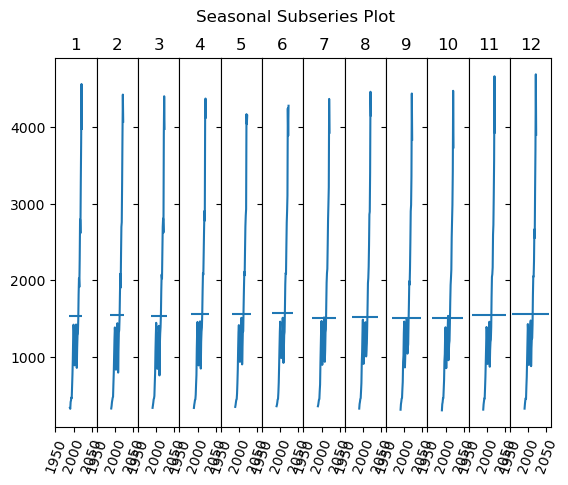

In [45]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack(0)

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iterrows()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')
    ax.set_xticklabels([int(thing) for thing in ax.get_xticks()], rotation = 70)

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


Text(0.5, 1.0, 'Lag plot with lag=1')

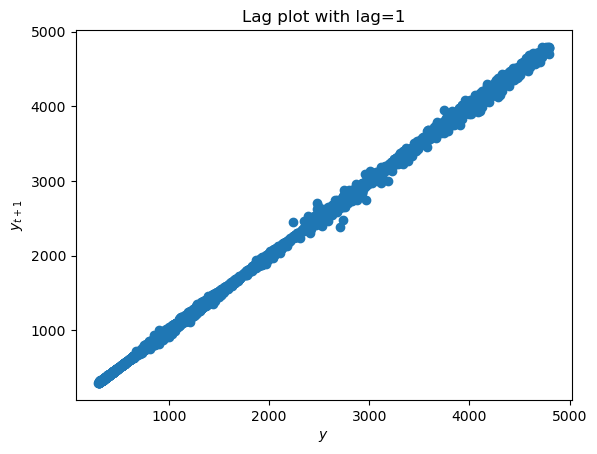

In [46]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


,open,high,low,close,volume,this_week,target,the_next_week
1990-01-07,356.880005,358.677505,353.527512,356.580009,1.724825e+08,355.105011,0.25,344.477997
1990-01-14,350.297998,351.340002,346.253998,347.835999,1.619160e+08,344.477997,0.20,337.173999
1990-01-21,338.657996,340.312006,335.674005,338.497998,1.722620e+08,337.173999,0.60,327.789996
1990-01-28,331.496002,333.067993,325.978003,328.825995,1.811940e+08,327.789996,0.20,328.724005
1990-02-04,326.370001,328.815997,324.090002,327.394006,1.690880e+08,328.724005,0.60,332.013995
...,...,...,...,...,...,...,...,...
2022-12-04,4010.807959,4050.027979,3981.900000,4029.989990,4.456116e+09,4036.970020,0.20,3952.725977
2022-12-11,3976.777979,3992.547998,3938.885986,3954.381982,4.132482e+09,3952.725977,0.40,3916.147998
2022-12-18,3974.697998,3998.941992,3920.267969,3950.728027,5.088678e+09,3916.147998,0.20,3839.304004
2022-12-25,3834.424023,3856.396045,3799.330029,3836.985986,3.701282e+09,3839.304004,0.60,3824.034973


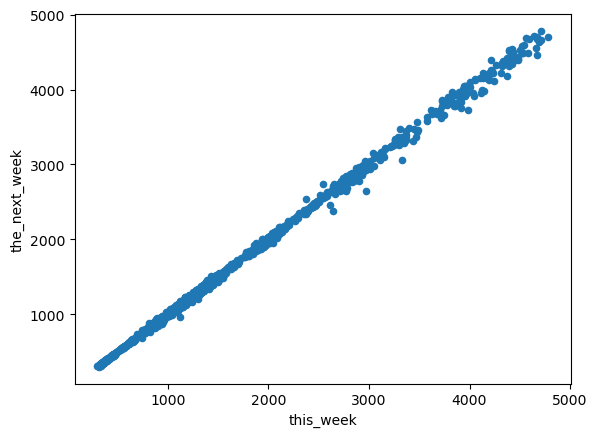

In [47]:
# 1 week out
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.tomorrow.shift(-1)
weekly = weekly.rename(columns={'tomorrow': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


,open,high,low,close,volume,this_week,target,12_weeks_out
1990-01-07,356.880005,358.677505,353.527512,356.580009,1.724825e+08,355.105011,0.25,340.586005
1990-01-14,350.297998,351.340002,346.253998,347.835999,1.619160e+08,344.477997,0.20,341.382001
1990-01-21,338.657996,340.312006,335.674005,338.497998,1.722620e+08,337.173999,0.60,343.267502
1990-01-28,331.496002,333.067993,325.978003,328.825995,1.811940e+08,327.789996,0.20,337.931995
1990-02-04,326.370001,328.815997,324.090002,327.394006,1.690880e+08,328.724005,0.60,331.043994
...,...,...,...,...,...,...,...,...
2022-12-04,4010.807959,4050.027979,3981.900000,4029.989990,4.456116e+09,4036.970020,0.20,NaN
2022-12-11,3976.777979,3992.547998,3938.885986,3954.381982,4.132482e+09,3952.725977,0.40,NaN
2022-12-18,3974.697998,3998.941992,3920.267969,3950.728027,5.088678e+09,3916.147998,0.20,NaN
2022-12-25,3834.424023,3856.396045,3799.330029,3836.985986,3.701282e+09,3839.304004,0.60,NaN


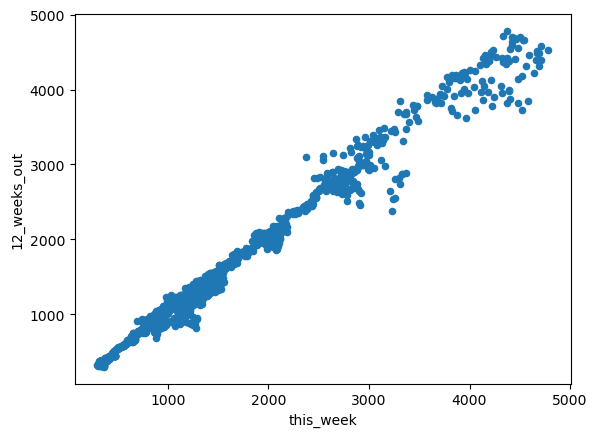

In [48]:
# 12 week lag
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.tomorrow.shift(-12)
weekly = weekly.rename(columns={'tomorrow': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

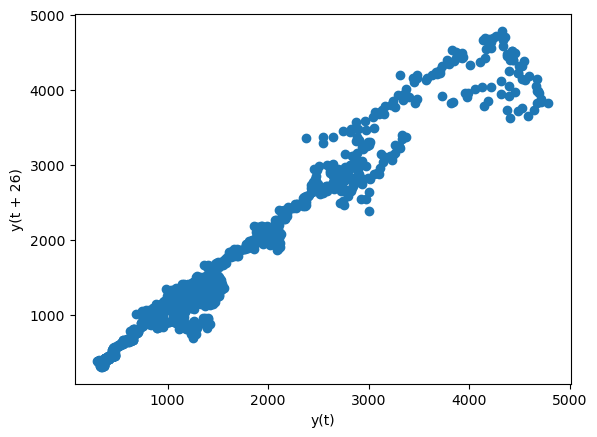

In [49]:
#26 week lag
pd.plotting.lag_plot(train.tomorrow.resample('W').mean(), lag=26)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

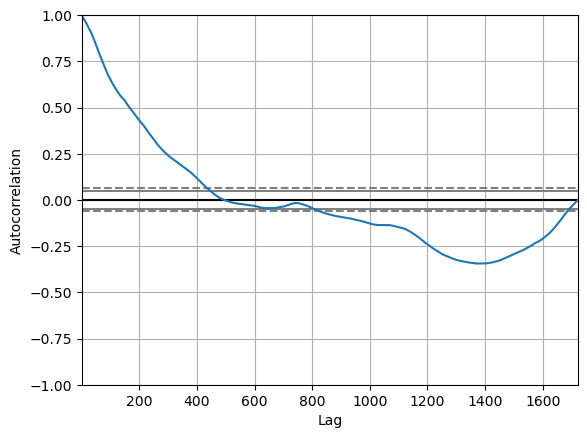

In [50]:
# autocorrolation
pd.plotting.autocorrelation_plot(train.tomorrow.resample('W').mean())


In [51]:
# seasonal decomposition
import statsmodels.api as sm

y = train.tomorrow.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
1990-01-07,355.105011,NaN,13.032556,NaN
1990-01-14,344.477997,NaN,6.913148,NaN
1990-01-21,337.173999,NaN,14.193647,NaN
1990-01-28,327.789996,NaN,12.812901,NaN
1990-02-04,328.724005,NaN,15.757549,NaN


In [52]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)



In [53]:
## models

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Create an empty DataFrame to store the results
#results_df = pd.DataFrame(columns=['Model', 'Parameters', 'AIC'])

# Baseline Models

# Last Observed Value
#last_observed_value = train['target'].iloc[-1]
#results_df.loc['Last Observed Value'] = ['Last Observed Value', None, np.nan]

# Simple Average
#simple_average = train['target'].mean()
#results_df.loc['Simple Average'] = ['Simple Average', None, np.nan]

# Moving Average
#moving_average = train['target'].rolling(window=3, min_periods=1).mean().iloc[-1]
#results_df.loc['Moving Average'] = ['Moving Average', None, np.nan]

# Non-Baseline Models

# Previous Cycle
#previous_cycle = train['target'].shift(12).iloc[-1]
#results_df.loc['Previous Cycle'] = ['Previous Cycle', None, np.nan]

# Holt's Linear Trend
#model = sm.tsa.Holt(train['target'])
#holt_linear_results = model.fit()
#results_df.loc["Holt's Linear Trend"] = ["Holt's Linear Trend", None, holt_linear_results.aic]

# Holt's Seasonal Trend
#model = sm.tsa.ExponentialSmoothing(train['target'], seasonal='add', seasonal_periods=12)
#holt_seasonal_results = model.fit()
#results_df.loc["Holt's Seasonal Trend"] = ["Holt's Seasonal Trend", None, holt_seasonal_results.aic]

# Print the results DataFrame
#print(results_df)


In [56]:
## pip install sktime

import pandas as pd
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Parameters', 'Accuracy'])

# Distance-based: KNN with dynamic time warping
#knn_dtw = KNeighborsTimeSeriesClassifier(distance="dtw")
#knn_dtw.fit(train['target'], train['date'])
#accuracy_knn_dtw = knn_dtw.score(test['target'], test['date'])
#results_df.loc['KNN with DTW'] = ['KNN with DTW', None, accuracy_knn_dtw]

# Interval-based: TimeSeriesForest
#tsf = TimeSeriesForestClassifier()
#tsf.fit(train.index, train['target'])
#accuracy_tsf = tsf.score(test.index, test['target'])
#results_df.loc['TimeSeriesForest'] = ['TimeSeriesForest', None, accuracy_tsf]



# Print the results DataFrame


# change to classification project  ####################

In [58]:
df=wrangle.get_sp500()

In [59]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23971 entries, 1927-12-30 00:00:00-05:00 to 2023-06-05 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          23971 non-null  float64
 1   High          23971 non-null  float64
 2   Low           23971 non-null  float64
 3   Close         23971 non-null  float64
 4   Volume        23971 non-null  int64  
 5   Dividends     23971 non-null  float64
 6   Stock Splits  23971 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5+ MB


In [62]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-06-05 00:00:00-04:00,4282.990234,4299.279785,4266.819824,4273.790039,2168511000,0.0,0.0


In [63]:
def prep_data(df):
    ''' this function preps the data set by:
    Creating a Tomorrow column as next day open procection based on close
    drop unneeded coloumns 'Dividends','Stock Split'
    set a target dummy column so 0=down and 1=up 
    set datetime index format
    '''
    # creating Tomorrow 
    df["Tomorrow"] = df["Close"].shift(-1)
    # make columns lower case
    df.columns = [col.lower() for col in df]
    # dropping unused columns
    df = df.drop(['stock splits', 'dividends'], axis=1)
    # setting up target column  as an int so that i get 0 for down days and 1 for up days
    df["target"] = (df["tomorrow"] > df["close"]).astype(int)
    #df.index = df.index.date
    df.index = pd.to_datetime(df.index, format = '%Y %m %d')
    # use a copy that only has dates from 1990 onwards
    df = df.loc["1990-01-01":].copy()  
    df = df.drop(df.index[-1])
    return df

In [65]:
# creating Tomorrow 
#df["Tomorrow"] = df["Close"].shift(-1)
# make columns lower case
#df.columns = [col.lower() for col in df]
# dropping unused columns
#df = df.drop(['stock splits', 'dividends'], axis=1)
# setting up target column  as an int so that i get 0 for down days and 1 for up days
#df["target"] = (df["tomorrow"] > df["close"]).astype(int)
#df.index = df.index.date
#df.index = pd.to_datetime(df.index, format = '%Y %m %d')
# use a copy that only has dates from 1990 onwards
#df = df.loc["1990-01-01":].copy()    

In [66]:
df.head()

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [68]:
#drop that last row with the nan- thats what we are trying to predict
df.reset_index()

,Date,open,high,low,close,volume,tomorrow,target
0,1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1,1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
2,1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
3,1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
4,1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...,...
23966,2023-05-30 00:00:00-04:00,4226.709961,4231.100098,4192.180176,4205.520020,4228510000,4179.830078,0
23967,2023-05-31 00:00:00-04:00,4190.740234,4195.439941,4166.149902,4179.830078,5980670000,4221.020020,1
23968,2023-06-01 00:00:00-04:00,4183.029785,4232.430176,4171.640137,4221.020020,4391860000,4282.370117,1
23969,2023-06-02 00:00:00-04:00,4241.009766,4290.669922,4241.009766,4282.370117,4454200000,4273.790039,0


In [69]:
def prep_data(df):
    ''' this function preps the data set by:
    Creating a Tomorrow column as next day open projection based on close
    dropping unneeded columns 'Dividends' and 'Stock Split'
    setting a target dummy column so 0=down and 1=up 
    setting datetime index format
    '''
    # Selecting data from 1990 onwards
    df = df.loc["1990-01-01":].copy()
    #reset index
    df = df.reset_index()

    # Make column names lowercase
    df.columns = [col.lower() for col in df]
    #drop time
    df.date = pd.to_datetime(df.date,utc=True).dt.date
    # Creating Tomorrow as next day's open projection based on close
    df["tomorrow"] = df["close"].shift(-1)
    # Dropping unused columns
    df = df.drop(['stock splits', 'dividends'], axis=1) 
    # Setting up target column as an int, 0 for down days and 1 for up days
    df["target"] = (df["tomorrow"] > df["close"]).astype(int)

    return df


In [ ]:
#df=acquire.get_sp500()

In [ ]:
#df = df.loc["1990-01-01":].copy()


In [ ]:
#df.head(1)

In [ ]:
d#f = df.reset_index()

In [73]:
#df.columns = [col.lower() for col in df]

# here

In [74]:
#df.head()

In [75]:
#df.date = pd.to_datetime(df.date,utc=True).dt.date

In [76]:
#df.date[0]

In [77]:
#df=acquire.get_sp500()

In [78]:
#df= prep_data(df)

In [79]:
#df.head()

In [80]:
def split_data(df):
    '''
    Be sure to code it as train, validate, test = split_data(df)
    take in a DataFrame and return train, validate, and test DataFrames; .
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.25, 
                                       random_state=123, 
                                       )
    #This confirms and Validates my split.
    
    print(f'train -> {train.shape}, {round(train.shape[0]*100 / df.shape[0],2)}%')
    print(f'validate -> {validate.shape},{round(validate.shape[0]*100 / df.shape[0],2)}%')
    print(f'test -> {test.shape}, {round(test.shape[0]*100 / df.shape[0],2)}%')
    
    return train, validate, test 

In [82]:
#train, validate, test = split_data(df)

## Test functions and start explore 

In [121]:
# start function test
df = wrangle.get_sp500()

In [122]:
df = wrangle.prep_data(df)

In [123]:
train, validate, test = wrangle.split_data(df)

train -> (5052, 8), 60.0%
validate -> (1684, 8),20.0%
test -> (1684, 8), 20.0%


In [124]:
df

,date,open,high,low,close,volume,tomorrow,target
0,1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1,1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
2,1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
3,1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
4,1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...,...
8415,2023-05-26,4156.160156,4212.870117,4156.160156,4205.450195,3715460000,4205.520020,1
8416,2023-05-30,4226.709961,4231.100098,4192.180176,4205.520020,4228510000,4179.830078,0
8417,2023-05-31,4190.740234,4195.439941,4166.149902,4179.830078,5980670000,4221.020020,1
8418,2023-06-01,4183.029785,4232.430176,4171.640137,4221.020020,4391860000,4282.370117,1


#### Viz

In [160]:
def get_distplot(train):
    '''
    creates a ditribution chart for the target variable target
    '''
    # Plot the distribution of the target variable
    plt.figure(figsize=(12, 3))
    sns.histplot(train['target'], kde=False, shrink=8)
    plt.xlabel('Target Buy Days')
    plt.ylabel('Count')
    plt.title('Distribution of Target buy days')
    # Add a vertical line for the baseline 
    plt.axvline(x=1, color='red', linestyle='--', label='Baseline')
    plt.legend()
    plt.show()

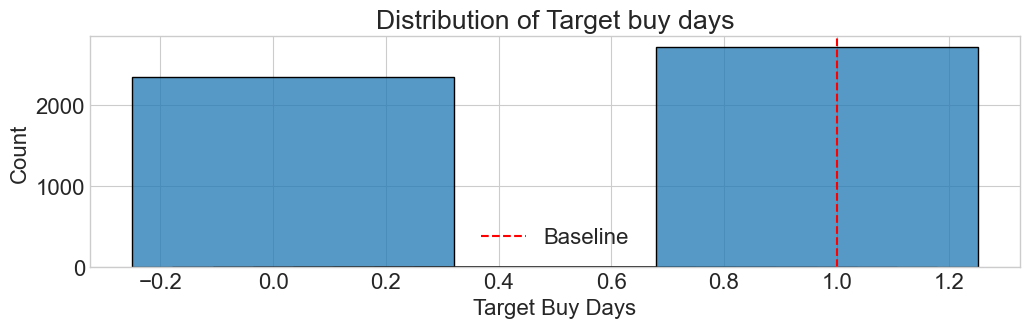

In [161]:
get_distplot(train)

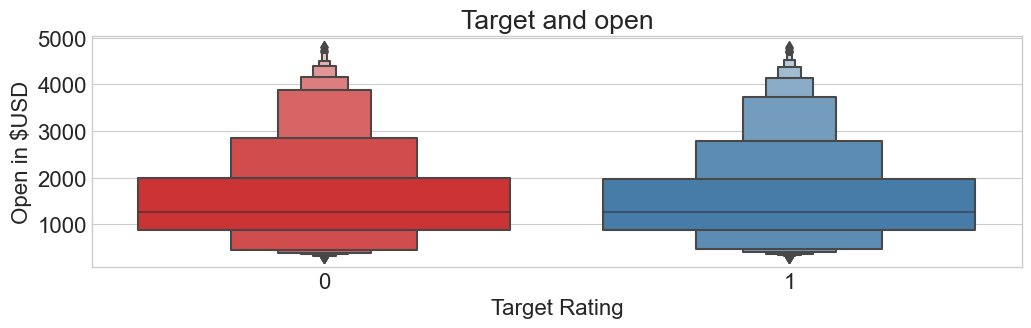

In [174]:
plt.figure(figsize=(12,3))
sns.boxenplot(data=train, x='target', y='open', palette='Set1')
plt.title('Target and open')
plt.ylabel('Open in $USD')
plt.xlabel('Target Rating')
plt.show()


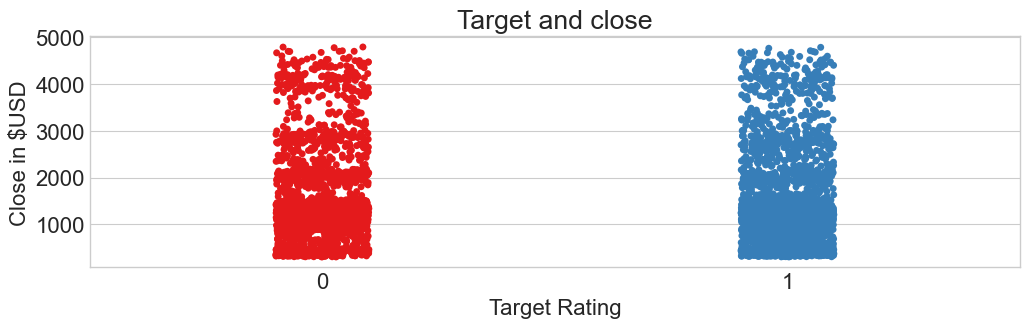

In [172]:
plt.figure(figsize=(12,3))
sns.stripplot(data=train, x='target', y='close', palette='Set1')
plt.title('Target and close')
plt.ylabel('Close in $USD')
plt.xlabel('Target Rating')
plt.show()

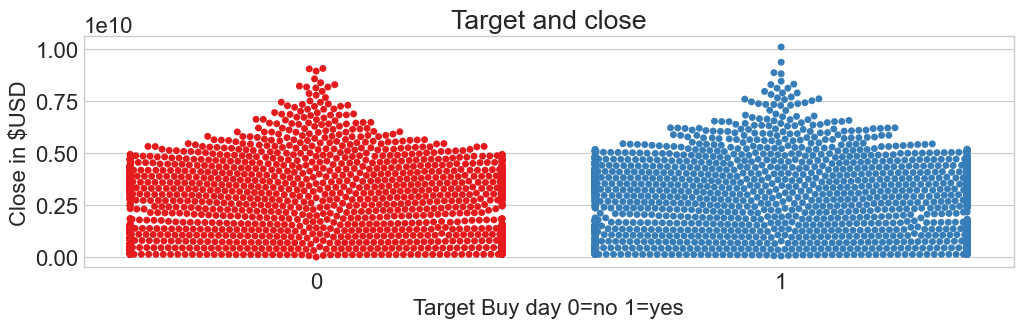

In [170]:
plt.figure(figsize=(12,3))
sns.swarmplot(data=train, x='target', y='volume', palette='Set1')
plt.title('Target and close')
plt.ylabel('Close in $USD')
plt.xlabel('Target Buy day 0=no 1=yes')
plt.show()

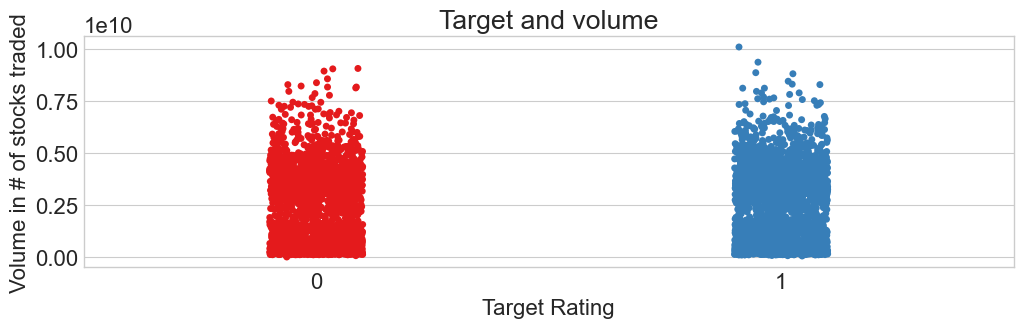

In [127]:
plt.figure(figsize=(12,3))
sns.stripplot(data=train, x='target', y='volume', palette='Set1')
plt.title('Target and volume')
plt.ylabel('Volume in # of stocks traded')
plt.xlabel('Target Rating')
plt.show()

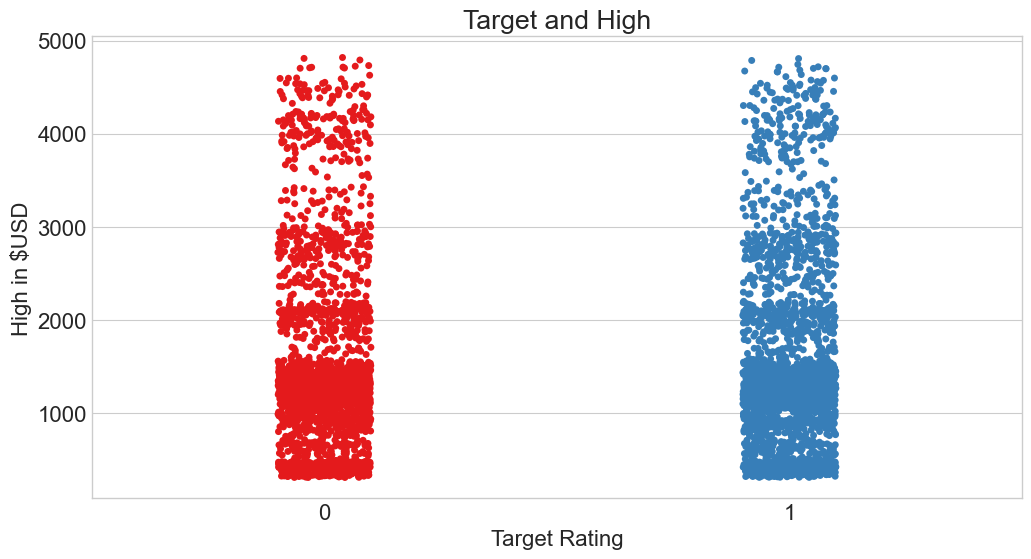

In [128]:
plt.figure(figsize=(12,6))
sns.stripplot(data=train, x='target', y='high', palette='Set1')
plt.title('Target and High')
plt.ylabel('High in $USD')
plt.xlabel('Target Rating')
plt.show()

<Figure size 1200x400 with 0 Axes>

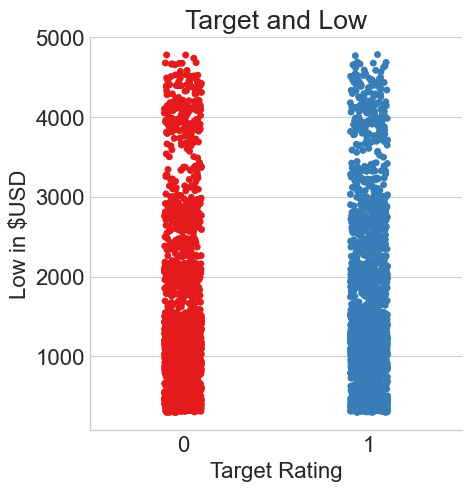

In [178]:
plt.figure(figsize=(12,4))
sns.catplot(data=train, x='target', y='low', palette='Set1')
plt.title('Target and Low')
plt.ylabel('Low in $USD')
plt.xlabel('Target Rating')
plt.show()

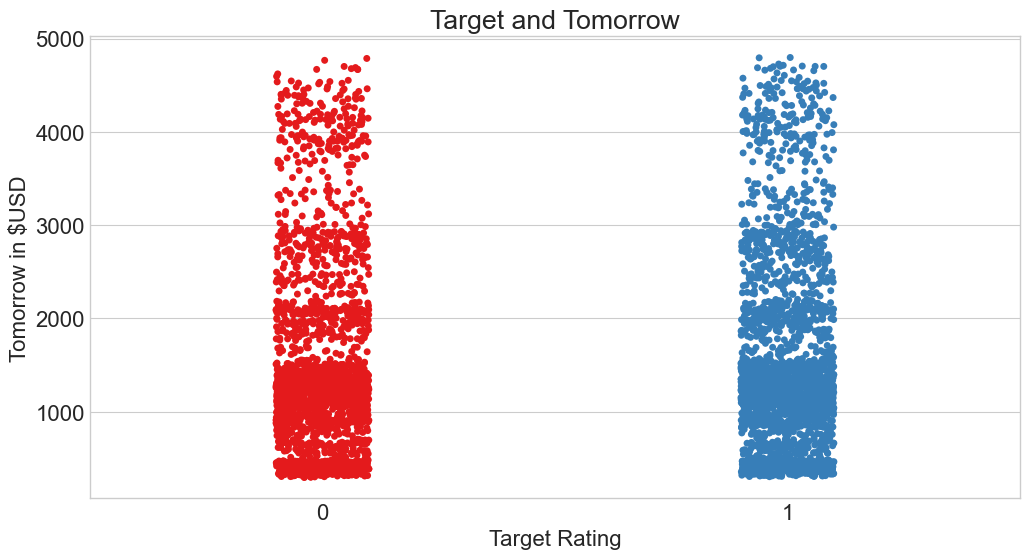

In [130]:
plt.figure(figsize=(12,6))
sns.stripplot(data=train, x='target', y='tomorrow', palette='Set1')
plt.title('Target and Tomorrow')
plt.ylabel('Tomorrow in $USD')
plt.xlabel('Target Rating')
plt.show()

#### Stat functions

In [131]:
import scipy.stats as stats

# Sklearn stuff:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score

from sklearn.model_selection import train_test_split

## Regression Models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

## Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [132]:
def run_low_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['low']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [133]:
# keep low
run_low_ttest(train)

,T-Statistic,P-Value,Decision
0,106.004816,0.0,Reject Null Hypothesis


In [134]:
def run_high_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['high']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [135]:
# keep high
run_high_ttest(train)

,T-Statistic,P-Value,Decision
0,106.089412,0.0,Reject Null Hypothesis


In [136]:
def run_open_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['open']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [137]:
# keep open
run_open_ttest(train)

,T-Statistic,P-Value,Decision
0,106.044653,0.0,Reject Null Hypothesis


In [138]:
def run_volume_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['volume']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [139]:
# keep volume
run_volume_ttest(train)

,T-Statistic,P-Value,Decision
0,93.753128,0.0,Reject Null Hypothesis


In [140]:
def run_close_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['close']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [141]:
# keep close
run_close_ttest(train)

,T-Statistic,P-Value,Decision
0,106.039801,0.0,Reject Null Hypothesis


In [142]:
def run_tomorrow_ttest(data):
    '''
    runs a Ttest for sulphates vs quality
    '''
    x = data['tomorrow']
    y = data['target']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value == alpha:
        decision = "Fail to Reject Null Hypothesis"
    else:
        decision = "Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]})
    return results

In [143]:
run_tomorrow_ttest(train)

,T-Statistic,P-Value,Decision
0,106.018902,0.0,Reject Null Hypothesis


#### Scale it

In [144]:
def scale_data(train, validate, test, columns):
    """
    Scale the selected columns in the train, validate, and test data.
    Args:
        train (pd.DataFrame): Training data.
        validate (pd.DataFrame): Validation data.
        test (pd.DataFrame): Test data.
        columns (list): List of column names to scale.
    Returns:
        tuple: Scaled data as (X_train_scaled, X_validate_scaled, X_test_scaled).
    """
    # create X & y version of train, where y is a series with just the target variable and X are all the features.
    X_train = train.drop(['target','date'], axis=1)
    y_train = train['target']
    X_validate = validate.drop(['target','date'], axis=1)
    y_validate = validate['target']
    X_test = test.drop(['target','date'], axis=1)
    y_test = test['target']
    # Create a scaler object
    scaler = MinMaxScaler()
    # Fit the scaler on the training data for the selected columns
    scaler.fit(X_train[columns])
    # Apply scaling to the selected columns in all data splits
    X_train_scaled = X_train.copy()
    X_train_scaled[columns] = scaler.transform(X_train[columns])

    X_validate_scaled = X_validate.copy()
    X_validate_scaled[columns] = scaler.transform(X_validate[columns])

    X_test_scaled = X_test.copy()
    X_test_scaled[columns] = scaler.transform(X_test[columns])
    return X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test

In [145]:
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = scale_data(train, validate, test, ['open', 'high','low','close','volume'])


In [146]:
X_train_scaled.shape

(5052, 6)

#### Baseline

In [147]:
def get_baseline(y_train):
    '''
    this function returns a baseline for precision
    '''
    baseline_prediction = y_train.median()
    # Predict the majority class in the training set
    baseline_pred = [baseline_prediction] * len(y_train)
    precision = precision_score(y_train, baseline_pred)
    baseline_results = {'Baseline': [baseline_prediction],'Metric': ['Precision'], 'Score': [precision]}
    baseline_df = pd.DataFrame(data=baseline_results)
    return baseline_df

In [148]:
get_baseline(y_train)

,Baseline,Metric,Score
0,1.0,Precision,0.536223


In [149]:
def create_models(seed=123):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    This includes best fit hyperparamaenters                
    '''
    models = []
    models.append(('k_nearest_neighbors', KNeighborsClassifier(n_neighbors=100)))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(max_depth=3,min_samples_split=4,random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(max_depth=3,random_state=seed)))
    return models

In [150]:
def get_models(train, validate, test):
    # create models list
    models = create_models(seed=123)
    X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = scale_data(train, validate, test, ['open', 'high','low','close','volume'])
    # initialize results dataframe
    results = pd.DataFrame(columns=['model', 'set', 'precision'])
    
    # loop through models and fit/predict on train and validate sets
    for name, model in models:
        # fit the model with the training data
        model.fit(X_train_scaled, y_train)
        
        # make predictions with the training data
        train_predictions = model.predict(X_train_scaled)
        
        # calculate training accuracy 
        train_precision = precision_score(y_train, train_predictions)
        
        
        # make predictions with the validation data
        val_predictions = model.predict(X_validate_scaled)
        
        # calculate validation accuracy and recall
        val_precision = precision_score(y_validate, val_predictions)
        
        
        # append results to dataframe
        results = results.append({'model': name, 'set': 'train', 'precision': train_precision}, ignore_index=True)
        results = results.append({'model': name, 'set': 'validate', 'precision': val_precision}, ignore_index=True)
        '''
        this section left in case I want to return to printed format rather than data frame
        # print classifier accuracy and recall
        print('Classifier: {}, Train Precision: {}, Validation Precision: {}'.format(name, train_precision, val_precision))
        '''
    return results,X_train_scaled, X_test_scaled,y_test,y_train

In [151]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

create_models(seed=123)
results,X_train_scaled, X_test_scaled,y_test,y_train=get_models(train, validate, test)
results

,model,set,precision
0,k_nearest_neighbors,train,0.558202
1,k_nearest_neighbors,validate,0.534551
2,logistic_regression,train,0.536223
3,logistic_regression,validate,0.530879
4,DecisionTreeClassifier,train,0.546312
5,DecisionTreeClassifier,validate,0.535220
6,random_forest,train,0.557994
7,random_forest,validate,0.542751


In [ ]:
# Best model is random forest

In [152]:
def get_test_model(X_train_scaled,y_test,y_train,X_test_scaled):
    '''
    This will run the random forest model on the test set
    To run past: explore.get_test_model(X_train_scaled,y_test,y_train,X_test_scaled)
    '''
    rf= RandomForestClassifier(max_depth=3,random_state=123)
    rf.fit(X_train_scaled, y_train)
    y_pred = rf.predict(X_test_scaled)
    precision = precision_score(y_test, y_pred)
    results_df = pd.DataFrame({'Model': 'Random_forest','Precision': [precision]})
    return results_df

In [153]:
get_test_model(X_train_scaled,y_test,y_train,X_test_scaled)

,Model,Precision
0,Random_forest,0.537231


In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5052 entries, 6024 to 904
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      5052 non-null   object 
 1   open      5052 non-null   float64
 2   high      5052 non-null   float64
 3   low       5052 non-null   float64
 4   close     5052 non-null   float64
 5   volume    5052 non-null   int64  
 6   tomorrow  5052 non-null   float64
 7   target    5052 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 355.2+ KB


TypeError: 'str' object is not callable

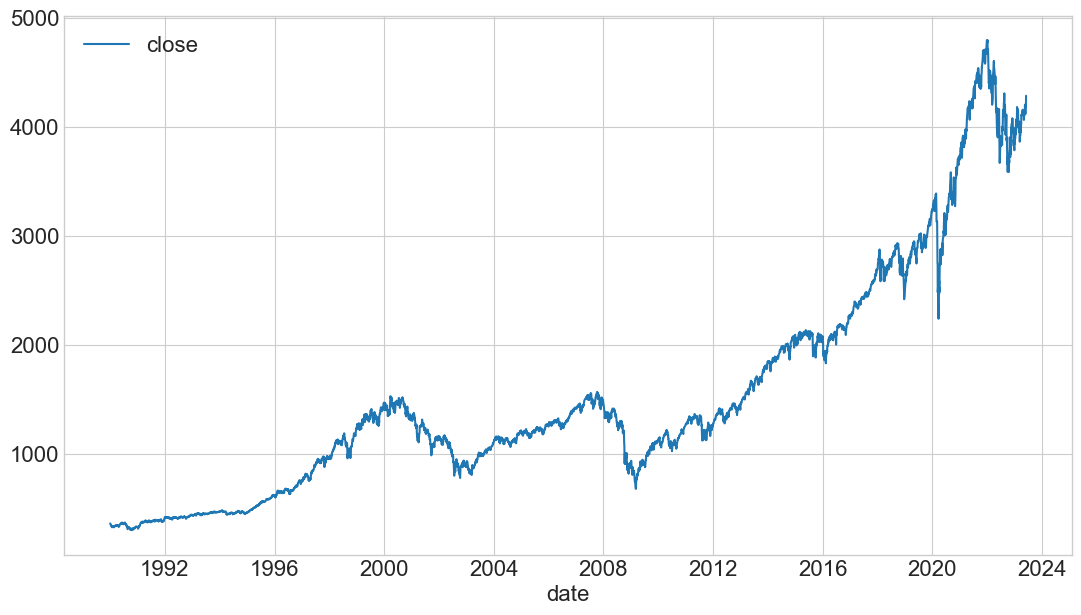

In [192]:
train.plot.line(y="close", x='date')
plt.title('S&P 500 Performance Since 1990')
plt.xlabel('Year')
plt.ylabel('Value in $USD')
plt.show()